Biblioteki

In [1]:
import os
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
import shutil
from sklearn.model_selection import train_test_split

Ścieżki i wstępne ustawienia

In [2]:
model_name = "model-grahp_classification_v4_crossvalid.keras"
# Ścieżka do katalogu z obrazami
edge_count = '4' # Liczba wierzchołków do nauki modelu
data_dir_generated = '../graph_generator/' + edge_count

# Wielkość obrazów i wielkość partii
img_height, img_width = 180, 180
batch_size = 32

In [3]:
def rgb_to_grayscale(images):
    return tf.image.rgb_to_grayscale(images)

Przenoszenie do katalogów

In [4]:
# Pobierz listę wszystkich katalogów z grafami
all_images_catalogs = os.listdir(data_dir_generated)

# Stwórz katalog "dane", jeśli jeszcze nie istnieje
data_dir = 'graphs_crossvalid'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
else:
    # Jeśli katalog "graphs_crossvalid" nie jest pusty, wyczyść go
    for filename in os.listdir(data_dir):
        file_path = os.path.join(data_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

# Skopiuj wszystkie obrazy do katalogu "graphs_crossvalid"
for catalog in all_images_catalogs:
    catalog_path = os.path.join(data_dir_generated, catalog)
    all_images = os.listdir(catalog_path)
    
    # Stwórz podkatalog w katalogu "graphs_crossvalid"
    new_catalog_path = os.path.join(data_dir, catalog)
    if not os.path.exists(new_catalog_path):
        os.makedirs(new_catalog_path)
    
    for image in all_images:
        shutil.copy(os.path.join(catalog_path, image), os.path.join(new_catalog_path, image))
        
# Pobierz listę wszystkich obrazów z katalogu "dane"
all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1] == '.png']

In [5]:
try:
    model = load_model(model_name)
    model_loaded = True
except:
    model_loaded = False

In [6]:
if (model_loaded == False):
    # Generowanie danych treningowych
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    class_names = train_ds.class_names
    train_ds = train_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

    # Generowanie danych walidacyjnych
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    val_ds = val_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

Found 2200 files belonging to 5 classes.
Using 1760 files for training.
Found 2200 files belonging to 5 classes.
Using 440 files for validation.


Model

In [7]:
if (model_loaded == False):
  n_splits = 5
  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
  history = []
  all_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) for f in filenames if os.path.splitext(f)[1] == '.png']

  for train_index, val_index in kfold.split(all_images):
    train_images = [all_images[i] for i in train_index]
    validation_images = [all_images[i] for i in val_index]

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        batch_size=batch_size)
    class_names = train_ds.class_names
    train_ds = train_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_height, img_width),
        batch_size=batch_size)
    val_ds = val_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ])
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(128, 3, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(len(class_names))
    ])

    model.compile(
      optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
    )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    history.append(model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=75,
      callbacks=[reduce_lr]
    ))

Found 2200 files belonging to 5 classes.
Found 2200 files belonging to 5 classes.
Epoch 1/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.5388 - loss: 11.0872 - val_accuracy: 0.2273 - val_loss: 72.3639 - learning_rate: 0.0010
Epoch 2/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 565ms/step - accuracy: 0.6843 - loss: 4.7258 - val_accuracy: 0.2273 - val_loss: 108.5766 - learning_rate: 0.0010
Epoch 3/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 623ms/step - accuracy: 0.7367 - loss: 3.3823 - val_accuracy: 0.2273 - val_loss: 81.3539 - learning_rate: 0.0010
Epoch 4/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 627ms/step - accuracy: 0.7385 - loss: 2.7193 - val_accuracy: 0.2273 - val_loss: 47.8758 - learning_rate: 0.0010
Epoch 5/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 624ms/step - accuracy: 0.7353 - loss: 2.3276 - val_accuracy: 0.2273 - val_loss: 88.3702 - learning_rate: 0.0010
Epoch 6/75
69/69 ━━━━━━━━━━━━━━━━━━━━ 46s 663ms/step - accuracy: 0.7168 - loss: 2.2548 - val_accuracy: 0.0909 - val_loss: 34.5677 - learning_rate:

In [8]:
model.save(model_name)

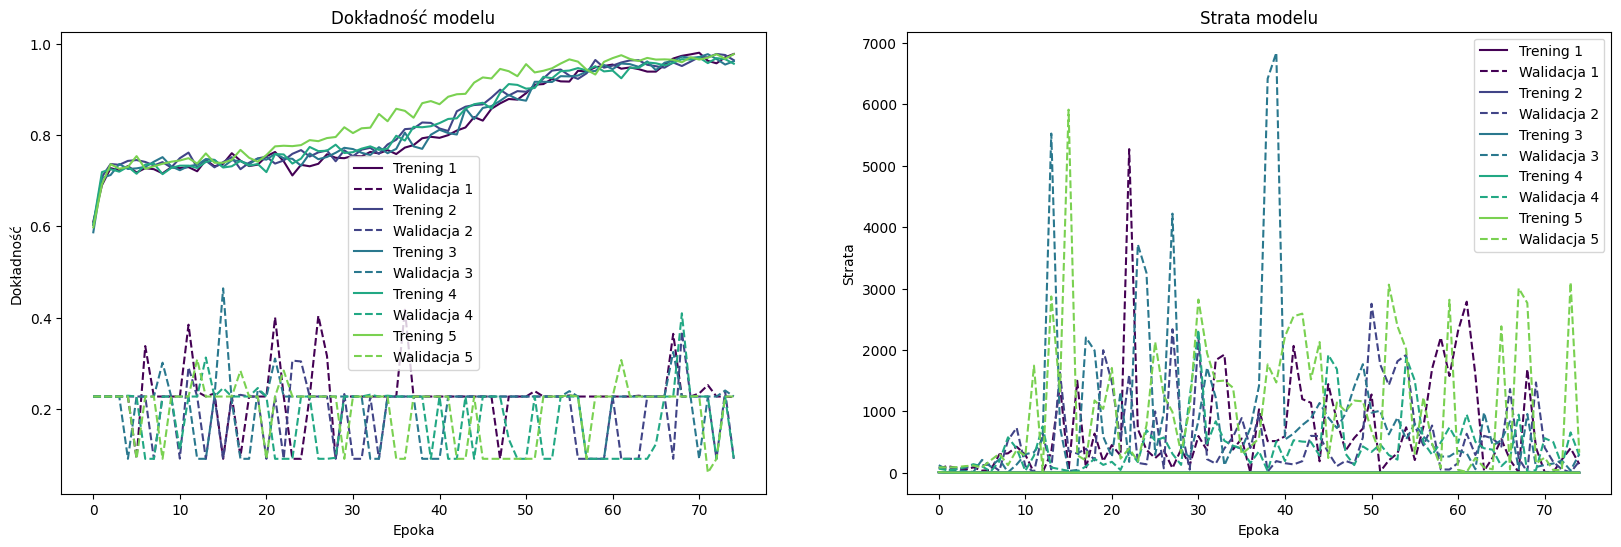

Średnia dokładność na zbiorze walidacyjnym: 17.25%


In [9]:
# Tworzymy figurę
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Dla każdego podziału
for i, h in enumerate(history):
    # Wybieramy kolor
    color = plt.cm.viridis(i / len(history))

    # Wykres dokładności
    ax1.plot(h.history['accuracy'], color=color, label='Trening {}'.format(i+1))
    ax1.plot(h.history['val_accuracy'], '--', color=color, label='Walidacja {}'.format(i+1))

    # Wykres straty
    ax2.plot(h.history['loss'], color=color, label='Trening {}'.format(i+1))
    ax2.plot(h.history['val_loss'], '--', color=color, label='Walidacja {}'.format(i+1))

# Ustawiamy tytuły i etykiety
ax1.set_title('Dokładność modelu')
ax1.set_ylabel('Dokładność')
ax1.set_xlabel('Epoka')
ax1.legend()

ax2.set_title('Strata modelu')
ax2.set_ylabel('Strata')
ax2.set_xlabel('Epoka')
ax2.legend()

# Wyświetlamy figurę
plt.show()

# Średnia dokładność na zbiorze walidacyjnym
average_accuracy = np.mean([h.history['val_accuracy'][-1] for h in history])
print("Średnia dokładność na zbiorze walidacyjnym: {:.2f}%".format(average_accuracy * 100))

In [10]:
h.history

{'accuracy': [0.5977272987365723,
  0.6918181777000427,
  0.735909104347229,
  0.7259091138839722,
  0.7300000190734863,
  0.753636360168457,
  0.7259091138839722,
  0.7313636541366577,
  0.7368181943893433,
  0.7413636445999146,
  0.7440909147262573,
  0.7490909099578857,
  0.7372727394104004,
  0.7595454454421997,
  0.7390909194946289,
  0.7390909194946289,
  0.7454545497894287,
  0.7672727108001709,
  0.75,
  0.7413636445999146,
  0.7559090852737427,
  0.7749999761581421,
  0.7763636112213135,
  0.7754545211791992,
  0.7777272462844849,
  0.7886363863945007,
  0.7863636612892151,
  0.793181836605072,
  0.7954545617103577,
  0.8168181777000427,
  0.8040909171104431,
  0.8145454525947571,
  0.8159090876579285,
  0.8459091186523438,
  0.8299999833106995,
  0.857272744178772,
  0.8527272939682007,
  0.8377272486686707,
  0.8695454597473145,
  0.8740909099578857,
  0.8672727346420288,
  0.8836363554000854,
  0.889090895652771,
  0.8899999856948853,
  0.914545476436615,
  0.92590910196304

In [11]:
def get_image_filenames(folder):
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filenames.append(filename)
    return filenames

In [12]:
# Zmieniamy funkcję, aby przeszukiwała również podkatalogi
def get_image_filenames(directory):
    return [os.path.join(root, name)
            for root, dirs, files in os.walk(directory)
            for name in files
            if name.endswith((".png", ".jpg", ".jpeg"))]

# Ścieżka do obrazu, który chcesz przetestować
test_photo_path = 'test_graphs'

test_photos = get_image_filenames(test_photo_path)
print(len(test_photos))
test_photos

14


['test_graphs\\drawn\\connected-drawn-1.png',
 'test_graphs\\drawn\\cycle-drawn-1.png',
 'test_graphs\\drawn\\full-drawn-1.jpg',
 'test_graphs\\drawn\\full-drawn-2.jpg',
 'test_graphs\\drawn\\full-drawn-3.png',
 'test_graphs\\drawn\\path-drawn-1.png',
 'test_graphs\\drawn\\path-drawn-2.png',
 'test_graphs\\drawn\\path-drawn-3.png',
 'test_graphs\\generated\\cycle-45.png',
 'test_graphs\\generated\\full-113.png',
 'test_graphs\\generated\\path-78.png',
 'test_graphs\\internet\\internet-cycle-1.png',
 'test_graphs\\internet\\internet-full-1.jpg',
 'test_graphs\\internet\\internet-full-2.jpg']

In [13]:
for test_photo in test_photos:
    # Wybór obrazka testowego
    image_path = test_photo

    # Wczytanie obrazu i dostosowanie go do odpowiedniego rozmiaru
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Przekształć obraz do skali szarości
    img_array = rgb_to_grayscale(img_array)
    # Rozszerz wymiary obrazu
    img_array = tf.expand_dims(img_array, 0)

    # Przewidywanie klasy obrazu
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "|- {} -| najprawdopodobniej należy do klasy |- {} -| z prawdopodobieństwem {:.2f} procent."
        .format(test_photo, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
|- test_graphs\drawn\connected-drawn-1.png -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 89.90 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
|- test_graphs\drawn\cycle-drawn-1.png -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 85.24 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
|- test_graphs\drawn\full-drawn-1.jpg -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 91.47 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- test_graphs\drawn\full-drawn-2.jpg -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 93.17 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
|- test_graphs\drawn\full-drawn-3.png -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 75.52 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
|- test_graphs\drawn\path-drawn-1.png -| najprawdopodobniej należy do klasy |- empty -| z prawdopodobieństwem 75.46 procent.
1/1 ━━━━━━━━━━━━